In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# inline plotting
%matplotlib inline

# Karting Pit Stops Optimization  
## From Entropy to Decision Tree Exploration.

### Problem to solve

We want to optimize a karting competition performance of a team for future competitions on the same track. Crutial task is to know when to pit stop and more precisely in which conditions to make the pit stops. In other words how long to stay on the track or how long should a stint be.

I want to start by exploring the entropy of each column (or variable) to understand our data better.

#### What is entropy? 
We can think of entropy as a measure of disorder or as a measure of purity as well. In information theory, [the entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a random variable is the average level of information, surprise, or uncertainty inherent to the descrete variable's possible outcomes. The mathematical formula is:

$$E(S) = - \sum_{i=1}^c p_i \log{_2}{p_i} $$

Where $E(S)$ is the entropy, $i$ is a random element in our dataset, and $p_i$ is the frequentist probability of an event.
The choice of base for  $\log$, the logarithm, varies for different applications. Base 2 gives the unit of bits (or "Shannon's" entropy), while base $e$ gives "natural units" nat.

#### What is entropy of continuous variables or continuous entropy?
We are trying to understand a dataset with karting competition results. In it, we see descrete and continuous variables. So we need a way to calculate entropy in continuous variables too, called continuous entropy. Here we can use the intuitions about limits and integrals computation. The mathematical equation formulated by Shanon, known as [differential entropy](https://en.wikipedia.org/wiki/Differential_entropy) is:

$$ H(X) = -\int_{-\infty}^{+\infty} f(x)\log f(x) d(x) $$

The solution of [numerical estimation of entropy](https://link.springer.com/article/10.1007/s40745-015-0045-9) for a continuous set of points is proposed by many authors. Those estimators come as an improvement of the formula, firstly given by Shanon.

#### Data import and summary

Let's now import our dataset and get sense of it.

In [2]:
# Import dataset

pit_stops = pd.read_csv("C:/Users/User/OneDrive/Documents/AI SoftUni 2023/Math for Dev 2023/0.Project/pit_stops_formatted.csv")
pit_stops.head()

,team id,category,n pit stop,n lap,cum race time,cum pit time,stint time,stint laps,pilot id,pilot total stint time,best lap,avg lap,pit time,cum time out,weather con
0,35,pro,1,39,0.030104,0.001609,0.030104,39,1,0.030104,0.000714,0.000742,0.001616,0.031713,moist
1,35,pro,2,84,0.062373,0.003183,0.030648,45,2,0.030648,0.007000,0.041000,0.001573,0.063947,moist
2,35,pro,3,131,0.094201,0.004769,0.030255,47,3,0.030255,0.018667,0.016000,0.001582,0.095787,moist
3,35,pro,4,180,0.126435,0.006343,0.030637,49,2,0.061296,0.037667,0.033667,0.001574,0.128009,dry
4,35,pro,5,229,0.158565,0.007917,0.030556,49,3,0.060822,0.025000,0.029667,0.001576,0.160150,dry


In [3]:
# View summary of the dataset

pit_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   team id                 933 non-null    int64  
 1   category                933 non-null    object 
 2   n pit stop              933 non-null    int64  
 3   n lap                   933 non-null    int64  
 4   cum race time           933 non-null    float64
 5   cum pit time            933 non-null    float64
 6   stint time              933 non-null    float64
 7   stint laps              933 non-null    int64  
 8   pilot id                933 non-null    int64  
 9   pilot total stint time  933 non-null    float64
 10  best lap                933 non-null    float64
 11  avg lap                 933 non-null    float64
 12  pit time                933 non-null    float64
 13  cum time out            933 non-null    float64
 14  weather con             933 non-null    ob

We have 933 observations and 15 columns. There are no null values. There are 3 different value types: 8 variables are float, 5 - integer type and 2 are categorical.

#### Data types transformations

We see that two of the variables ("category" and "weather con") are categorical types, that we won't be able to work with. We need to change them to numerical types.

In [4]:
# Change categorical values into numerical values using dictionaries

dic1 = {"pro": 3, "gold": 2, "silver": 1, "DSQ": 0}
dic2 = {"dry": 1, "moist": 2, "wet": 3}
pit_stops["category"] = pit_stops["category"].map(dic1)
pit_stops["weather con"] = pit_stops["weather con"].map(dic2)

pit_stops.head()

,team id,category,n pit stop,n lap,cum race time,cum pit time,stint time,stint laps,pilot id,pilot total stint time,best lap,avg lap,pit time,cum time out,weather con
0,35,3,1,39,0.030104,0.001609,0.030104,39,1,0.030104,0.000714,0.000742,0.001616,0.031713,2
1,35,3,2,84,0.062373,0.003183,0.030648,45,2,0.030648,0.007000,0.041000,0.001573,0.063947,2
2,35,3,3,131,0.094201,0.004769,0.030255,47,3,0.030255,0.018667,0.016000,0.001582,0.095787,2
3,35,3,4,180,0.126435,0.006343,0.030637,49,2,0.061296,0.037667,0.033667,0.001574,0.128009,1
4,35,3,5,229,0.158565,0.007917,0.030556,49,3,0.060822,0.025000,0.029667,0.001576,0.160150,1


What we did is to map the different states (string values) with numbers and replace them in our columns.

#### Calculate entropy of the data according to the type of values - descrete or continuous

Now let's calculate the entropy of each column. We need to separate descrete from continuous variables and calculate them separately. Continuous entropy is a relative entropy, not absolute. They have their own scale, which differs from the scale of the descrete values' entropy.  

We can use scipy.stats library directly or build a function. Let's define a function as this is the main goal of this project. :)

In [5]:
# Define descrete variables

descrete_vars = pit_stops[["team id", "category", "n pit stop", "pilot id", "weather con"]]

# Function to compute descrete entropy

def descrete_entropy(dataset = descrete_vars):
    num_el = len(dataset)
    val_counts = dataset.value_counts()
    probs = val_counts / num_el
    base = 2            # setting bits as a measure unit
    
    en = - np.sum(probs * np.log(probs) / np.log(base))
    return en

# Showing entropy per each variable

vars_en_desc = descrete_vars.apply(descrete_entropy, axis = 0)
vars_en_desc

team id        5.640294
category       1.688049
n pit stop     4.294470
pilot id       1.715749
weather con    1.537311
dtype: float64

#### Scale up the results

Let's scale up what we get to receive entropy between 0 and 1, although it is not crucial for the comparison. However, it's more intuitive. We need to multiply the values with $\log$ with a base number of the parameters in the dataset. In my case, 5. I am using [change of base log rule](https://en.wikipedia.org/wiki/Logarithm#Change_of_base).

$$\log {_b} x = \frac {\log {_c} x} {\log {_c} b} $$

In [6]:
# Scaling them up to get numbers between 0 and 1

base = 5
vars_en_desc_scaled = np.log(vars_en_desc) / np.log(base)

vars_en_desc_scaled

team id        1.074870
category       0.325315
n pit stop     0.905489
pilot id       0.335428
weather con    0.267196
dtype: float64

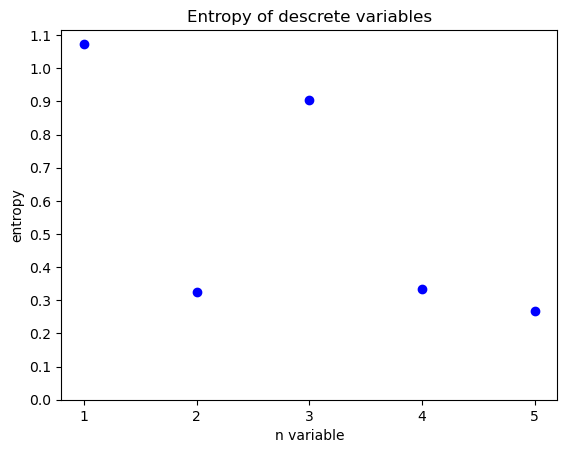

In [7]:
# Plot the entropy of descrete varables

def plot_en():
    plt.scatter(np.arange(1, len(vars_en_desc_scaled) + 1, 1), vars_en_desc_scaled, c = "b")
    plt.xlabel("n variable")
    plt.ylabel("entropy")
    plt.title("Entropy of descrete variables")
    plt.xticks(np.arange(1, 6, 1))
    plt.yticks(np.arange(0, 1.2, 0.1))
    return plt.show()
plot_en()

#### Continuous variables
Now let's see what is going on with the entropy of all other features.

In [8]:
# Define continuous variables

continuous_vars = pit_stops.drop(["team id", "category", "n pit stop", "pilot id", "weather con"], axis = 1)

# Function to calculate continuous entropy using scipy.stats library

def continuous_en(dataset = continuous_vars):   
    con_en = stats.differential_entropy(dataset)
    return con_en

# Showing entropy per each variable

vars_con_en = continuous_vars.apply(continuous_en, axis = 0)
vars_con_en

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_entropy.py:380: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))


n lap                     5.934575
cum race time            -1.275828
cum pit time                  -inf
stint time               -3.988572
stint laps                    -inf
pilot total stint time   -1.888840
best lap                      -inf
avg lap                       -inf
pit time                      -inf
cum time out             -1.283559
dtype: float64

We see that we have encountered a "divide by zero" error. Checking the data shows that we do not have zeros, but very small integers. Let's check the PDF of one of the continuous variables - column "stint laps" in more detail.

(array([201.,  11.,  22.,   8.,  27.,  21.,  13.,  23.,  29.,  16.,  32.,
         27.,  27.,  13.,  23.,  34.,  28.,  24.,  33.,  13.,  22.,  34.,
         27.,   9.,  35.,  35.,  28.,  57.,  60.,   1.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ,
        19.7, 21.4, 23.1, 24.8, 26.5, 28.2, 29.9, 31.6, 33.3, 35. , 36.7,
        38.4, 40.1, 41.8, 43.5, 45.2, 46.9, 48.6, 50.3, 52. ]),
 <BarContainer object of 30 artists>)

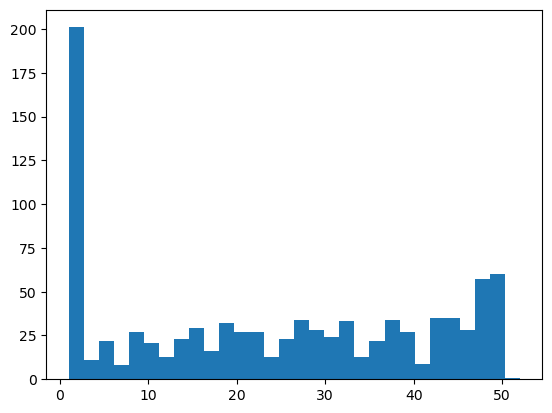

In [9]:
# Vizualize stint laps values

plt.hist(pit_stops["stint laps"], bins = 30)

We see high occurance of the value "1" in the data. 201 of total 933 observations show to be "1".

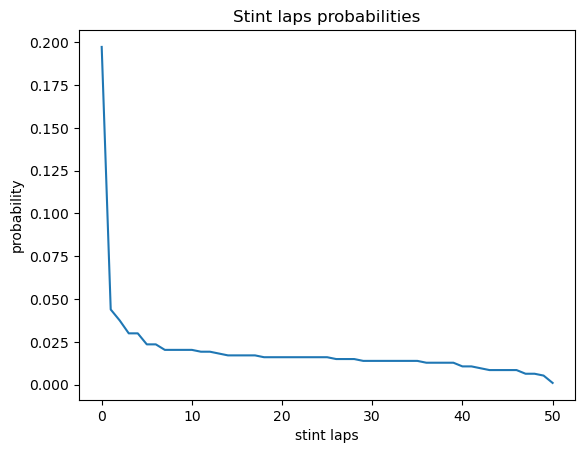

In [10]:
# Function to calculate frequentist probability

def prob(dataset):   
    num_el = len(dataset)
    val_counts = dataset.value_counts()
    probs = val_counts / num_el
    return probs

# Vizualize probabilities 
prob_stintlaps = np.array(prob(pit_stops["stint laps"]))

plt.plot(np.arange(0, len(prob_stintlaps)), prob_stintlaps)
plt.xlabel("stint laps")
plt.ylabel("probability")
plt.title("Stint laps probabilities")
plt.show()

This distribution looks to be exponential. Let's build a function to calculate the continuous entropy of an exponential probability distribution.

In [11]:
# Function to calculate continuous entropy of an exponential distribution

def continuous_entropy(pdf, x):
    min_x = np.min(x)
    max_x = np.max(x)
    pdf = pdf(x)
    
    entropy = - np.trapz(pdf * np.log(pdf), x)
    return entropy

# Checking entropy of "Stint laps" column

x = prob_stintlaps
mu = np.mean(x)
sigma = np.std(x)

entropy = continuous_entropy(lambda x: stats.expon.pdf(x, mu, sigma), prob_stintlaps)
entropy

C:\Users\User\AppData\Local\Temp\ipykernel_14800\1324376159.py:8: RuntimeWarning: divide by zero encountered in log
  entropy = - np.trapz(pdf * np.log(pdf), x)
C:\Users\User\AppData\Local\Temp\ipykernel_14800\1324376159.py:8: RuntimeWarning: invalid value encountered in multiply
  entropy = - np.trapz(pdf * np.log(pdf), x)


nan

We get the same error message because we get zero values in the pdf. $ - \infty $ results for the entropy are due to the encounter of values in the pdf whose probability are essentially zeros.

Nevertheless we can get rid of the negative values for the entropy by transforming the data. We get negative values, as we are working with very small values. I am going to multiply them by $$\frac {1}{x}$$

In [12]:
# Let's transform the data and calculate entropy for continuous variables again 

small_vars = np.array(continuous_vars.drop(["n lap"], axis = 1))
transformed_vars = 1 / small_vars

vars_en_con = stats.differential_entropy(transformed_vars)
vars_en_con

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_entropy.py:380: RuntimeWarning: divide by zero encountered in log
  logs = np.log(n * differences / (ci * m))


array([2.26665502,       -inf, 5.4372038 ,       -inf, 3.63206283,
             -inf,       -inf,       -inf, 2.22957197])

In [13]:
# Scaling them up to get numbers between 0 and 1

base = 9
vars_en_con_scaled = np.log(vars_en_con) / np.log(base)

vars_en_con_scaled

C:\Users\User\AppData\Local\Temp\ipykernel_14800\2264522350.py:4: RuntimeWarning: invalid value encountered in log
  vars_en_con_scaled = np.log(vars_en_con) / np.log(base)


array([0.37242674,        nan, 0.77063808,        nan, 0.58701362,
              nan,        nan,        nan, 0.36491929])

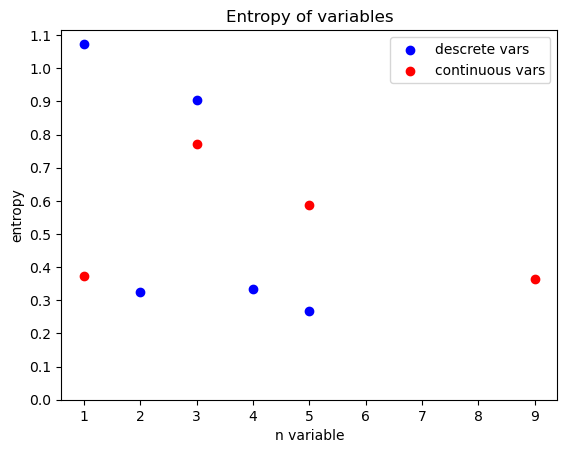

In [14]:
# Plot the entropy of descrete and continuous varables

def plot_en():
    plt.scatter(np.arange(1, len(vars_en_desc_scaled) + 1, 1), vars_en_desc_scaled, c = "b", label = "descrete vars")
    plt.scatter(np.arange(1, len(vars_en_con_scaled) + 1, 1), vars_en_con_scaled, c = "r", label = "continuous vars")
    plt.xlabel("n variable")
    plt.ylabel("entropy")
    plt.title("Entropy of variables")
    plt.xticks(np.arange(1, 10, 1))
    plt.yticks(np.arange(0, 1.2, 0.1))
    plt.legend()
    return plt.show()
plot_en()

#### Analyzing what we have

Descrete

We see two variables with a high order of disorder - above 0.9 ("team id", "n pit stop"). The other three columns ("category", "pilot id", "weather con") show relatively low entropy - around 0.3. This is expected, as those three columns consist of three groups of values each.

Continuous

Columns "cum race time" and "cum time out" show entropy - around 0.4. Columns "stint time" and "pilot total stint time" are with entropy - between 0.59 and 0.77.
Five of the variables have $-\infty$ entropy.

One column is left outside the scaled entropies: "n lap", so we can't compare its entropy (5.93) at all.

#### Building a decision tree

We want to optimize the karting competition performance of a team in future competitions on the same track. The crucial task is to know when to pit stop and more precisely how long to stay on the track. There are three variables directly connected to our task: 
 1. "stint time", the duration of stints between pit stops
 2. "stint laps", the summation of laps between pit stops 
 
From our exploration of the entropy of the variables we see that their entropy is: 
 1. "stint time"  0.8
 2. "stint laps"  - $\infty$

Feature "stint time" shows high entropy among continuous features. Variable "stint laps" can't be evaluated properly, so let's choose it as the target variable for our tree.

In [15]:
# Separate the feature columns from the target column

features = pit_stops.drop(["stint laps"], axis = 1)
X = features
y = pit_stops["stint laps"]
X, y

(     team id  category  n pit stop  n lap  cum race time  cum pit time  \
 0         35         3           1     39       0.030104      0.001609   
 1         35         3           2     84       0.062373      0.003183   
 2         35         3           3    131       0.094201      0.004769   
 3         35         3           4    180       0.126435      0.006343   
 4         35         3           5    229       0.158565      0.007917   
 ..       ...       ...         ...    ...            ...           ...   
 928       28         1          16    332       0.250220      0.025394   
 929       28         1          17    361       0.272234      0.026968   
 930       28         1          18    378       0.290926      0.028542   
 931       28         1          19    398       0.313345      0.030139   
 932       28         1          20    421       0.334016      0.000100   
 
      stint time  pilot id  pilot total stint time  best lap   avg lap  \
 0      0.030104        

In [16]:
# Split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 11)

In [17]:
# Check the shape of X_train and X_test

X_train.shape, X_test.shape

((653, 14), (280, 14))

In [18]:
# Check formatting

X_train.dtypes

team id                     int64
category                    int64
n pit stop                  int64
n lap                       int64
cum race time             float64
cum pit time              float64
stint time                float64
pilot id                    int64
pilot total stint time    float64
best lap                  float64
avg lap                   float64
pit time                  float64
cum time out              float64
weather con                 int64
dtype: object

In [19]:
# Build a decision tree with criterion entropy

clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [20]:
# Predict the Test set results with criterion entropy

y_pred_entropy = clf_entropy.predict(X_test)

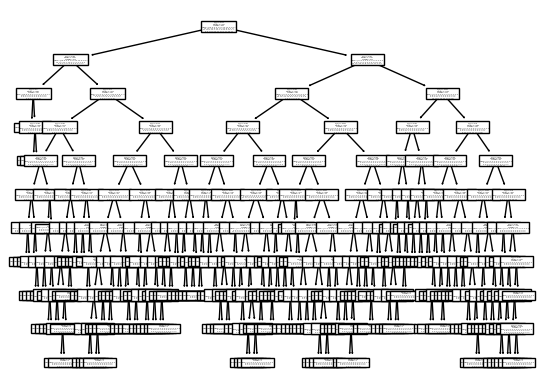

In [21]:
# Plot the tree

tree.plot_tree(clf_entropy)
plt.show()

In [22]:
# Predict the Test set results with criterion entropy

y_pred_entropy = clf_entropy.predict(X_test)

# Check accuracy score with criterion entropy

print("Model accuracy score: {0:0.4f}".format(accuracy_score(y_test, y_pred_entropy)))

Model accuracy score: 0.5679


When heterogenity is strongly present in the data, decision trees tent to branch out a lot. So let's check our model for overfitting. Fast check shows that the increase in max depth above 10 do not improve accurcy. So let's set a max depth to 10.

In [23]:
# Lets do it better

clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth = 10, random_state = 0)
clf_entropy.fit(X_train, y_train)

# Predict the Test set results with criterion entropy

y_pred_entropy = clf_entropy.predict(X_test)

# Check accuracy score with criterion entropy

print("Model accuracy score: {0:0.4f}".format(accuracy_score(y_test, y_pred_entropy)))

Model accuracy score: 0.5679


In [24]:
# Let's vizualize the predicted outcoumes

y_pred_entropy

array([ 1, 36, 49, 29,  5, 38,  1, 34, 49, 16, 47, 37, 46, 29, 47,  1,  5,
        1, 38,  1, 22, 25, 47, 25,  1,  1,  8,  1, 24, 23, 39, 14,  2,  6,
       26, 49, 14,  1, 17,  1, 29, 18, 44, 12, 13,  1,  1, 18, 49, 50, 47,
       10, 48, 37,  9, 14, 28,  1,  1, 49, 26, 22,  3,  2,  1,  1, 43, 32,
        1, 24, 18, 37,  1, 19, 15,  1, 44, 47, 14,  1, 49, 36, 46, 49, 45,
       38, 12, 18, 28, 14, 43, 29, 47, 41, 50, 27, 48, 44, 17,  5, 43, 12,
       30, 50, 13, 29, 45, 49, 37, 47, 32,  1, 38, 25,  1, 17, 38, 50, 48,
       14,  1,  6, 24,  1, 11,  6, 44, 38,  1, 47, 37, 26, 28,  1, 49, 42,
       29, 28, 40, 42, 41, 43, 14,  6, 49, 41, 22, 25, 21,  1, 31,  1,  8,
       43, 39,  1, 11,  2, 22,  2, 47,  5,  6,  9, 46,  1,  2, 33,  2,  1,
        1, 24, 43,  1, 32, 32, 14, 41, 46, 25,  9, 42, 28, 16, 29, 10, 37,
       32, 31, 30, 43,  1, 17,  5,  7, 34,  8, 47, 15, 42, 47,  2,  1, 37,
       34, 50, 32, 14,  4,  8, 26, 25, 12,  1, 21, 50, 21, 46, 48, 14, 47,
       35, 15, 49, 32, 49

### Conclusion

After an exploration of the entropy of the dataset, we see that variables of interest are rather heterogeneous than homogeneous, also many are "not readable". Thus the data is harder to be modeled. It looks to me like there are too many branches of our tree. The model we built doesn't have the needed simplicity and shows an unsatisfying prediction accuracy score (0.57). It needs more work and further optimizations.

## References

[wikipedia.org](https://en.wikipedia.org/)

["Decision-Tree Classification with Python and Scikit-Learn" git hub](https://gist.github.com/pb111/af439e4affb1dd94879579cfd6793770)

["Entropy Estimation Using Numerical Methods" link.springer.com ](https://link.springer.com/article/10.1007/s40745-015-0045-9)

["Entropy: How Decision Trees Make Decisions" towardsdatascience.com](https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8)